## Import modules


In [1]:
from data_access.firebase_fhir_data_access import FirebaseFHIRAccess
from data_flattening.fhir_resources_flattener import flatten_fhir_resources, FHIRDataFrame
from data_processing.data_processor import FHIRDataProcessor
from data_visualization.data_visualizer import DataVisualizer, visualizer_factory
from data_export.data_exporter import DataExporter

## Define credential files

In [2]:
# Define your Firebase project ID
project_id = "spezi-data-pipeline"  # Replace with your Firebase project ID

# Define the service account key file
service_account_key_file = "path_to_service_account_key_file.json"  # Replace with your service account key file

# Define the collection name where your FHIR observations are stored and the input code if filtering is needed
collection_name = "users"
subcollection_name = "HealthKit"

# Define the list of HealthKit quantities to query from Firebase Firestore
loinc_codes = ["55423-8"]

## Initialize the FirebaseFHIRAccess class using your Firebase credentials

In [3]:
## Initialize the FirebaseFHIRAccess class using your Firebase credentials
firebase_access = FirebaseFHIRAccess(project_id, service_account_key_file)
firebase_access.connect()

fhir_observations = firebase_access.fetch_data(collection_name, subcollection_name, loinc_codes)

flattened_fhir_dataframe = flatten_fhir_resources(fhir_observations)

In [4]:
flattened_fhir_dataframe.df.head()

,UserId,EffectiveDateTime,QuantityName,LoincCode,Display,AppleHealthKitCode,QuantityUnit,QuantityValue
0,XrftRMc358NndzcRWEQ7P2MxvabZ,2023-04-26,Step Count,55423-8,Number of steps in unspecified time Pedometer,HKQuantityTypeIdentifierStepCount,steps,1
1,XrftRMc358NndzcRWEQ7P2MxvabZ,2023-06-28,Step Count,55423-8,Number of steps in unspecified time Pedometer,HKQuantityTypeIdentifierStepCount,steps,170.0
2,sEmijWpn0vXe1cj60GO5kkjkrdT4,2023-03-10,Step Count,55423-8,Number of steps in unspecified time Pedometer,HKQuantityTypeIdentifierStepCount,steps,129.0


## Apply basic processing for convenient data readability

In [5]:
processed_fhir_dataframe = FHIRDataProcessor().process_fhir_data(flattened_fhir_dataframe)
processed_fhir_dataframe.df.head() 

,UserId,EffectiveDateTime,LoincCode,QuantityValue,AppleHealthKitCode,QuantityUnit,QuantityName,Display
0,XrftRMc358NndzcRWEQ7P2MxvabZ,2023-04-26,55423-8,1,HKQuantityTypeIdentifierStepCount,steps,Total daily Step Count,Number of steps in unspecified time Pedometer
1,XrftRMc358NndzcRWEQ7P2MxvabZ,2023-06-28,55423-8,170.0,HKQuantityTypeIdentifierStepCount,steps,Total daily Step Count,Number of steps in unspecified time Pedometer
2,sEmijWpn0vXe1cj60GO5kkjkrdT4,2023-03-10,55423-8,129.0,HKQuantityTypeIdentifierStepCount,steps,Total daily Step Count,Number of steps in unspecified time Pedometer


## Visualize Data

### HealthKit Quantity Example

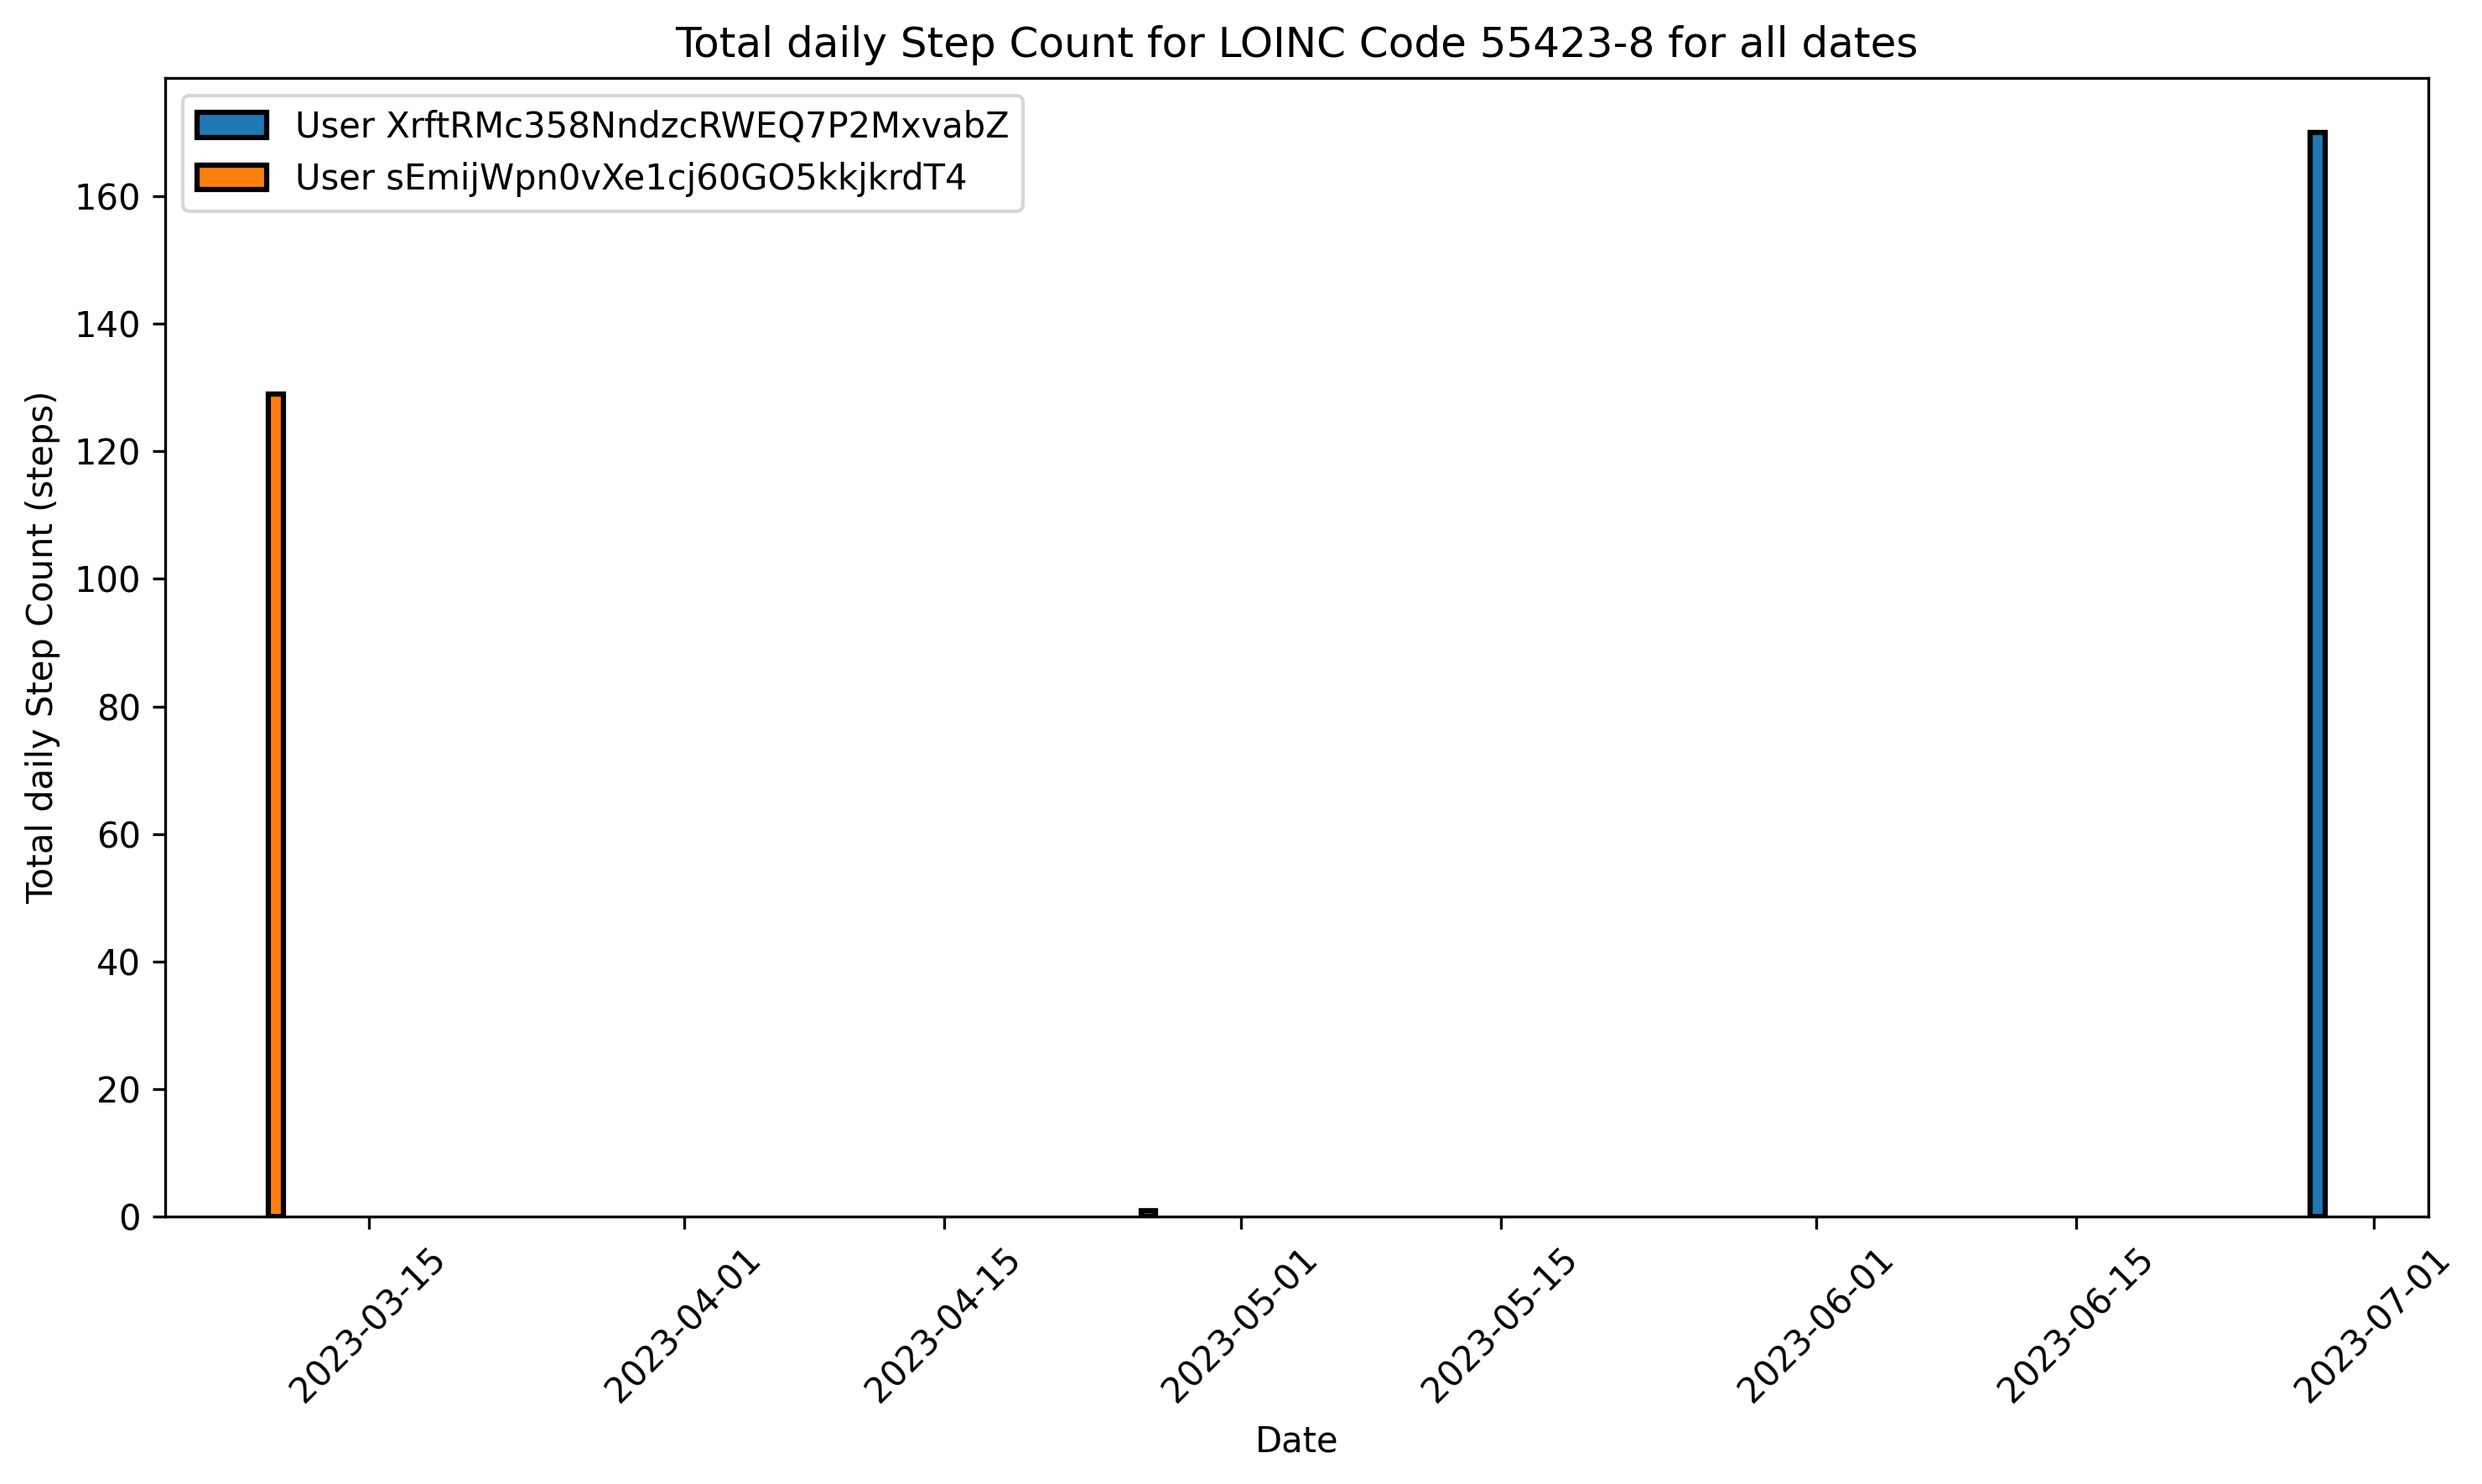

In [6]:
selected_users = ["3EUoHxIuYkWMKcnLfK38nTGOqHn1","7uMKVmPZdwgtb9hc6r9YZyYXnwc2", "sgsxyilwB3T3xf3LIvkpSajN3NW2"]
selected_start_date = "2024-02-22"
selected_end_date = "2024-04-2"
visualizer = visualizer_factory(processed_fhir_dataframe)

# visualizer.set_user_ids(selected_users)
# visualizer.set_date_range(selected_start_date, selected_end_date)
# visualizer.set_y_bounds(50, 50000)

figs = visualizer.create_static_plot(processed_fhir_dataframe)

### ECG Recording Example

In [7]:
# selected_users = ["k3BnzOGAO0fIaxkDVXTZKlj3LAu2", "3EUoHxIuYkWMKcnLfK38nTGOqHn1"]

# selected_start_date = "2023-03-13"
# selected_end_date = "2023-03-13"

# visualizer = visualizer_factory(processed_fhir_dataframe)
# visualizer.set_user_ids(selected_users)
# visualizer.set_date_range(selected_start_date, selected_end_date)
# figs = visualizer.plot_ecg_subplots(processed_fhir_dataframe) 

## Export data

In [8]:
selected_users = ["sEmijWpn0vXe1cj60GO5kkjkrdT4"]

exporter = DataExporter(processed_fhir_dataframe)
exporter.set_user_ids(selected_users)
exporter.set_date_range(selected_start_date, selected_end_date)
exporter.set_date_range(selected_start_date, selected_start_date)
# exporter.create_and_save_plot("data_plot") 